# Exploring Pretrained CNN Models from PyTorch

This notebook explores various pretrained Convolutional Neural Network (CNN) architectures available in PyTorch's `torchvision.models` module. We'll examine:

- Model architectures and their key innovations
- Training datasets (primarily ImageNet)
- Number of trainable parameters
- Visualization of convolutional feature maps using forward hooks

## Models Covered
1. **AlexNet** (2012)
2. **VGG** (2014)
3. **ResNet/ResNet50** (2015)
4. **DenseNet** (2016)
5. **MobileNetV2** (2018)
6. **EfficientNet** (2019)

All models in this notebook are pretrained on **ImageNet** (ILSVRC 2012), which contains 1.2 million images across 1000 classes.

## Setup and Imports

In [15]:
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from typing import Dict, List
import requests
from io import BytesIO

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cuda


## Utility Functions

In [16]:
def count_parameters(model):
    """
    Count total and trainable parameters in a model.
    """
    total_params = sum(p.numel() for p in model.parameters())
    trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    
    print(f"Total parameters: {total_params:,}")
    print(f"Trainable parameters: {trainable_params:,}")
    print(f"Size (MB): {total_params * 4 / (1024**2):.2f}")  # Assuming float32
    
    return total_params, trainable_params


def get_feature_maps(model, layer_name, input_tensor):
    """
    Extract feature maps from a specific layer using hooks.
    """
    feature_maps = {}
    
    def hook_fn(module, input, output):
        feature_maps['output'] = output.detach()
    
    # Register hook
    hook = None
    for name, layer in model.named_modules():
        if name == layer_name:
            hook = layer.register_forward_hook(hook_fn)
            break
    
    if hook is None:
        print(f"Layer '{layer_name}' not found!")
        return None
    
    # Forward pass
    model.eval()
    with torch.no_grad():
        _ = model(input_tensor)
    
    # Remove hook
    hook.remove()
    
    return feature_maps.get('output', None)


def visualize_feature_maps(feature_maps, num_maps=16, title="Feature Maps"):
    """
    Visualize feature maps from a convolutional layer.
    """
    if feature_maps is None:
        print("No feature maps to visualize")
        return
    
    # Get first batch item
    feature_maps = feature_maps[0].cpu().numpy()
    
    # Limit number of feature maps to visualize
    num_channels = min(num_maps, feature_maps.shape[0])
    
    # Create grid
    cols = 4
    rows = (num_channels + cols - 1) // cols
    
    fig, axes = plt.subplots(rows, cols, figsize=(12, 3*rows))
    axes = axes.flatten() if num_channels > 1 else [axes]
    
    for idx in range(num_channels):
        ax = axes[idx]
        fmap = feature_maps[idx]
        ax.imshow(fmap, cmap='viridis')
        ax.axis('off')
        ax.set_title(f'Channel {idx}')
    
    # Hide unused subplots
    for idx in range(num_channels, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(title, fontsize=16)
    plt.tight_layout()
    plt.show()


def load_sample_image(url=None):
    """
    Load a sample image for testing.
    """
    if url is None:
        # Default image: a cat
        url = "https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg"
    
    response = requests.get(url)
    img = Image.open(BytesIO(response.content)).convert('RGB')
    
    return img


def preprocess_image(img, size=224):
    """
    Preprocess image for model input.
    """
    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])
    
    return transform(img).unsqueeze(0)


def print_layer_names(model, max_depth=2):
    """
    Print layer names in the model (helpful for finding layers for hooks).
    """
    print("\nLayer names (for hook registration):")
    for name, module in model.named_modules():
        depth = name.count('.')
        if depth <= max_depth and isinstance(module, (nn.Conv2d, nn.ReLU, nn.MaxPool2d, nn.BatchNorm2d)):
            print(f"  {name}: {module.__class__.__name__}")


def get_imagenet_labels():
    """
    Load ImageNet class labels.
    """
    url = "https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt"
    response = requests.get(url)
    labels = response.text.strip().split('\n')
    return labels


def get_top5_predictions(model, input_tensor, labels):
    """
    Get top-5 predictions from a model.
    """
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        probabilities = torch.nn.functional.softmax(outputs[0], dim=0)
    
    # Get top 5 predictions
    top5_prob, top5_idx = torch.topk(probabilities, 5)
    
    return top5_prob.cpu().numpy(), top5_idx.cpu().numpy()


def display_top5_predictions(model, input_tensor, labels, model_name):
    """
    Display top-5 predictions in a nice format.
    """
    top5_prob, top5_idx = get_top5_predictions(model, input_tensor, labels)
    
    print(f"\n{'=' * 60}")
    print(f"{model_name} - TOP-5 PREDICTIONS")
    print(f"{'=' * 60}")
    for i, (prob, idx) in enumerate(zip(top5_prob, top5_idx)):
        print(f"{i+1}. {labels[idx]:30s} {prob*100:5.2f}%")
    print(f"{'=' * 60}\n")

## Load Sample Image

We'll use the same image across all models for consistent feature map visualization.

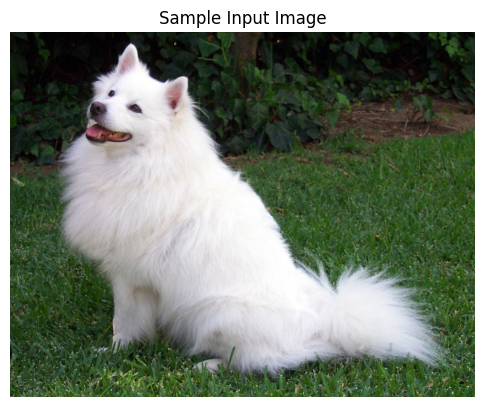

Input tensor shape: torch.Size([1, 3, 224, 224])


In [17]:
# Load and display sample image
sample_img = load_sample_image()
plt.figure(figsize=(6, 6))
plt.imshow(sample_img)
plt.axis('off')
plt.title('Sample Input Image')
plt.show()

# Preprocess for models
input_tensor = preprocess_image(sample_img).to(device)
print(f"Input tensor shape: {input_tensor.shape}")

In [18]:
# Load ImageNet class labels
print("Loading ImageNet class labels...")
imagenet_labels = get_imagenet_labels()
print(f"Loaded {len(imagenet_labels)} class labels")

Loading ImageNet class labels...
Loaded 1000 class labels


---
# 1. AlexNet (2012)

## Overview
**AlexNet** revolutionized computer vision by winning the ImageNet Large Scale Visual Recognition Challenge (ILSVRC) 2012 with a top-5 error rate of 15.3%, significantly outperforming the second-place entry (26.2%).

### Key Innovations:
- First successful deep CNN for image classification
- Used ReLU activation instead of tanh/sigmoid
- Implemented dropout for regularization
- Used GPU acceleration (trained on 2 GTX 580 GPUs)
- Data augmentation and local response normalization

### Architecture:
- 5 convolutional layers
- 3 fully connected layers
- Max pooling and dropout

**Paper:** *ImageNet Classification with Deep Convolutional Neural Networks*  
Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012)  
[NeurIPS 2012 Paper](https://papers.nips.cc/paper/2012/hash/c399862d3b9d6b76c8436e924a68c45b-Abstract.html)

### Architecture Diagram:
![AlexNet Architecture](https://viso.ai/wp-content/uploads/2024/04/alexNet-architecture.png)

In [19]:
# Load pretrained AlexNet
alexnet = models.alexnet(pretrained=True).to(device)
alexnet.eval()

print("=" * 60)
print("ALEXNET ARCHITECTURE")
print("=" * 60)
print(alexnet)
print("\n" + "=" * 60)
print("PARAMETER COUNT")
print("=" * 60)
count_parameters(alexnet)

ALEXNET ARCHITECTURE
AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_featur

(61100840, 61100840)

In [20]:
# Get AlexNet Top-5 Predictions
display_top5_predictions(alexnet, input_tensor, imagenet_labels, "AlexNet")


AlexNet - TOP-5 PREDICTIONS
1. wallaby                        91.32%
2. Angora                          2.90%
3. Samoyed                         2.71%
4. Persian cat                     0.96%
5. Pomeranian                      0.70%



In [21]:
# Print layer names for AlexNet
print_layer_names(alexnet)


Layer names (for hook registration):
  features.0: Conv2d
  features.1: ReLU
  features.2: MaxPool2d
  features.3: Conv2d
  features.4: ReLU
  features.5: MaxPool2d
  features.6: Conv2d
  features.7: ReLU
  features.8: Conv2d
  features.9: ReLU
  features.10: Conv2d
  features.11: ReLU
  features.12: MaxPool2d
  classifier.2: ReLU
  classifier.5: ReLU


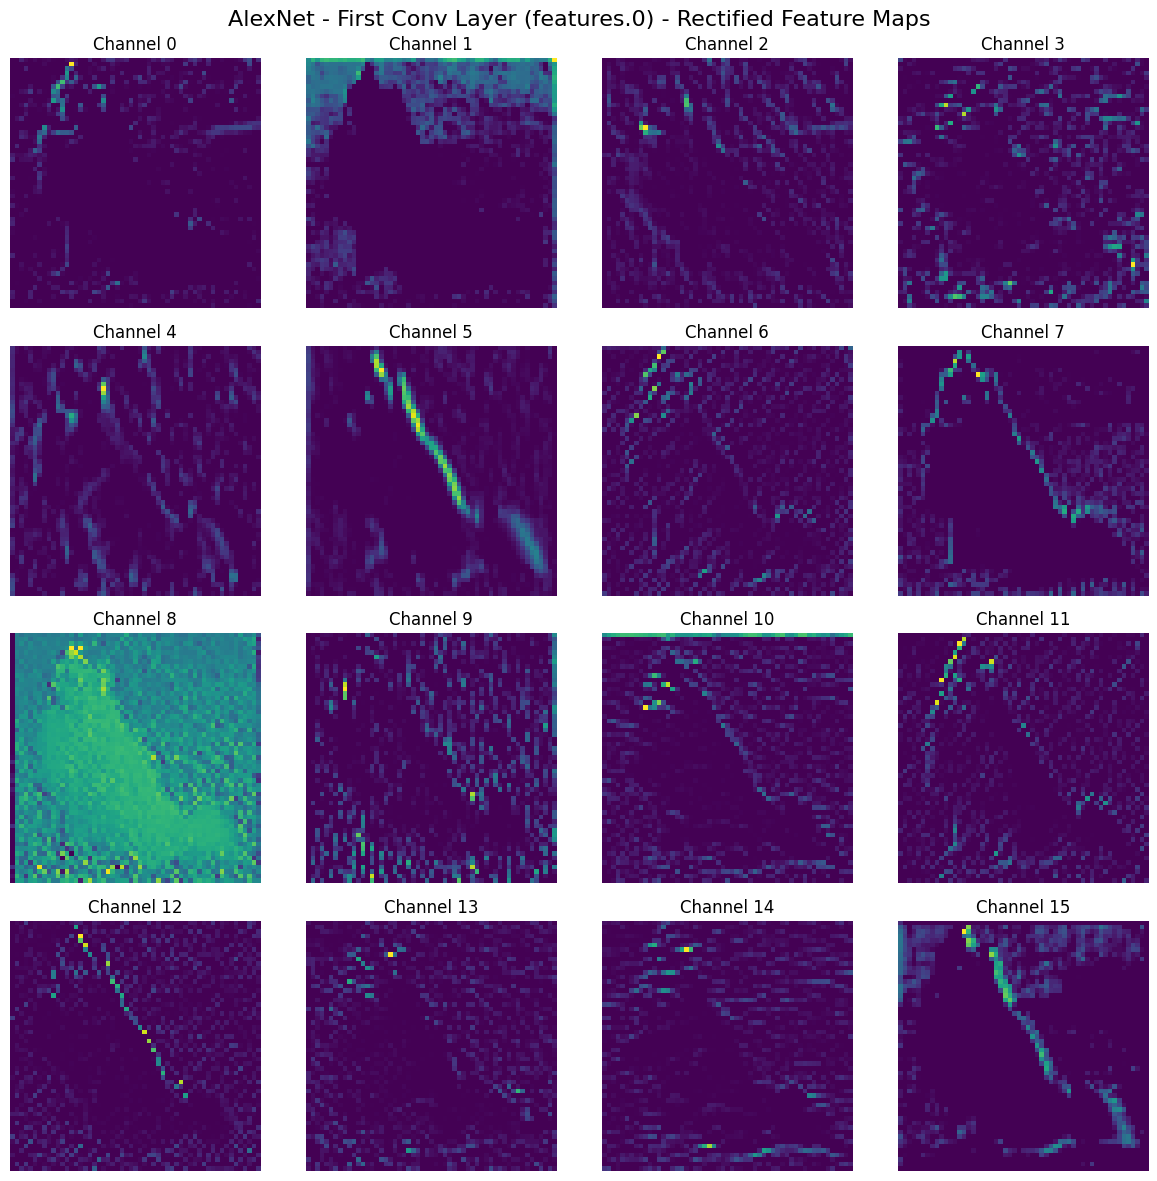

In [22]:
# Visualize feature maps from first convolutional layer
feature_maps = get_feature_maps(alexnet, 'features.0', input_tensor)
visualize_feature_maps(feature_maps, num_maps=16, 
                      title="AlexNet - First Conv Layer (features.0) - Rectified Feature Maps")

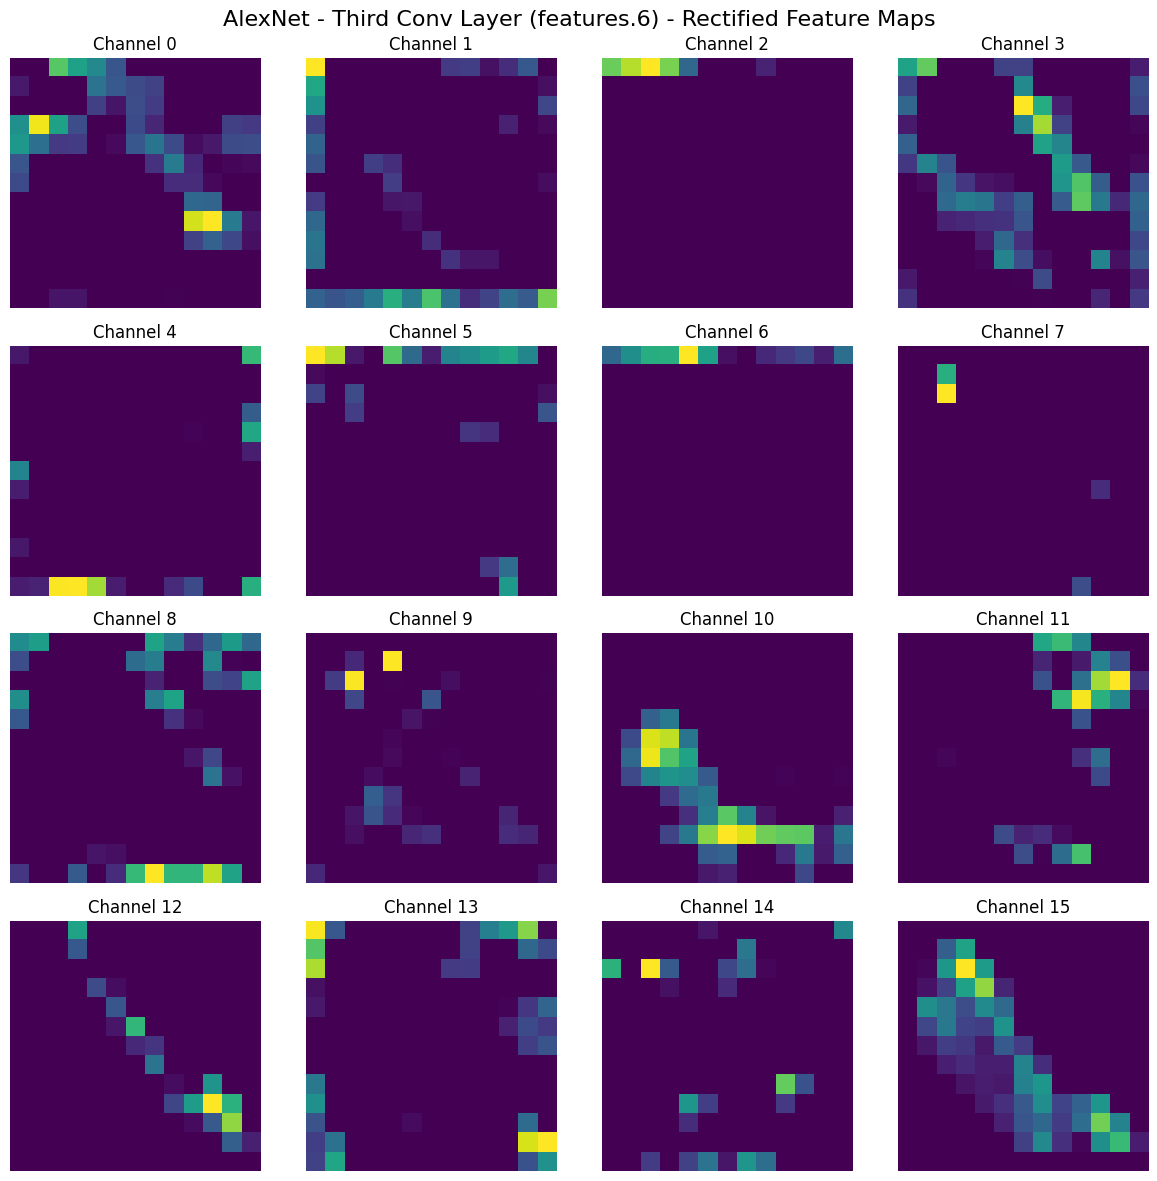

In [23]:
# Visualize feature maps from deeper layer
feature_maps = get_feature_maps(alexnet, 'features.6', input_tensor)
visualize_feature_maps(feature_maps, num_maps=16, 
                      title="AlexNet - Third Conv Layer (features.6) - Rectified Feature Maps")

---
# 2. VGG (2014)

## Overview
**VGG** (Visual Geometry Group) networks demonstrated that depth is critical for good performance. VGG networks use very small (3×3) convolution filters throughout.

### Key Innovations:
- Consistent use of 3×3 convolutions
- Deep architecture (16-19 layers)
- Simple and homogeneous architecture
- Two 3×3 convolutions have same receptive field as one 5×5 but with fewer parameters

### Architecture Variants:
- **VGG-11**: 8 conv layers + 3 FC layers
- **VGG-13**: 10 conv layers + 3 FC layers
- **VGG-16**: 13 conv layers + 3 FC layers (most popular)
- **VGG-19**: 16 conv layers + 3 FC layers

**Paper:** *Very Deep Convolutional Networks for Large-Scale Image Recognition*  
Simonyan, K., & Zisserman, A. (2014)  
[ICLR 2015 Paper](https://arxiv.org/abs/1409.1556)

### Architecture Diagram:
![VGG Architecture](https://viso.ai/wp-content/uploads/2024/04/vgg-16.bak.png)

In [ ]:
# Load pretrained VGG16
vgg16 = models.vgg16(pretrained=True).to(device)
vgg16.eval()

print("=" * 60)
print("VGG16 ARCHITECTURE")
print("=" * 60)
print(vgg16)
print("\n" + "=" * 60)
print("PARAMETER COUNT")
print("=" * 60)
count_parameters(vgg16)

In [ ]:
# Print layer names for VGG16
print_layer_names(vgg16)

In [ ]:
# Visualize feature maps from early layer
feature_maps = get_feature_maps(vgg16, 'features.2', input_tensor)  # After first conv block
visualize_feature_maps(feature_maps, num_maps=16, 
                      title="VGG16 - First Conv Block (features.2) - Rectified Feature Maps")

In [ ]:
# Visualize feature maps from deeper layer
feature_maps = get_feature_maps(vgg16, 'features.16', input_tensor)  # Middle layers
visualize_feature_maps(feature_maps, num_maps=16, 
                      title="VGG16 - Deep Conv Layer (features.16) - Rectified Feature Maps")

### ResNet50 Predictions on Sample Image

In [ ]:
# Get ResNet50 Top-5 Predictions
display_top5_predictions(vgg16, input_tensor, imagenet_labels, "VGG16")

---
# 3. ResNet and ResNet50 (2015)

## Overview
**ResNet** (Residual Network) introduced skip connections (residual connections) that allow gradients to flow through the network directly, enabling training of very deep networks (up to 1000+ layers).

### Key Innovations:
- **Residual blocks**: Skip connections that add input to output: F(x) + x
- Solves vanishing gradient problem
- Identity mappings allow easier optimization
- Batch normalization after every convolution
- Won ILSVRC 2015 with 3.57% top-5 error

### Architecture Variants:
- **ResNet-18**: 18 layers
- **ResNet-34**: 34 layers
- **ResNet-50**: 50 layers (uses bottleneck blocks)
- **ResNet-101**: 101 layers
- **ResNet-152**: 152 layers

**Paper:** *Deep Residual Learning for Image Recognition*  
He, K., Zhang, X., Ren, S., & Sun, J. (2016)  
[CVPR 2016 Paper](https://arxiv.org/abs/1512.03385)

### Architecture Diagram:
![ResNet Architecture](https://towardsdatascience.com/wp-content/uploads/2022/08/0tH9evuOFqk8F41FG.png)

### Residual Block:
![Residual Block](https://miro.medium.com/v2/resize:fit:1400/1*D0F3UitQ2l5Q0Ak-tjEdJg.png)

In [ ]:
# Load pretrained ResNet50
resnet50 = models.resnet50(pretrained=True).to(device)
resnet50.eval()

print("=" * 60)
print("RESNET50 ARCHITECTURE")
print("=" * 60)
print(resnet50)
print("\n" + "=" * 60)
print("PARAMETER COUNT")
print("=" * 60)
count_parameters(resnet50)

In [ ]:
# Print layer names for ResNet50
print_layer_names(resnet50, max_depth=3)

In [ ]:
# Visualize feature maps from early layer
feature_maps = get_feature_maps(resnet50, 'relu', input_tensor)  # After first conv+bn+relu
visualize_feature_maps(feature_maps, num_maps=16, 
                      title="ResNet50 - Initial Conv Block (relu) - Rectified Feature Maps")

In [ ]:
# Visualize feature maps from residual block
feature_maps = get_feature_maps(resnet50, 'layer2.0.relu', input_tensor)
visualize_feature_maps(feature_maps, num_maps=16, 
                      title="ResNet50 - Layer 2 Residual Block - Rectified Feature Maps")

In [ ]:
# Also load ResNet18 for comparison
resnet18 = models.resnet18(pretrained=True).to(device)
resnet18.eval()

print("=" * 60)
print("RESNET18 vs RESNET50 COMPARISON")
print("=" * 60)
print("\nResNet18:")
count_parameters(resnet18)
print("\nResNet50:")
count_parameters(resnet50)

In [42]:
# Get ResNet50 Top-5 Predictions

# Get ResNet18 Top-5 Predictions


---
# 4. DenseNet (2016)

## Overview
**DenseNet** (Densely Connected Convolutional Networks) connects each layer to every other layer in a feed-forward fashion. For L layers, there are L(L+1)/2 direct connections.

### Key Innovations:
- **Dense connectivity**: Each layer receives feature maps from all preceding layers
- Feature reuse leads to more compact models
- Alleviates vanishing gradient problem
- Reduces number of parameters compared to ResNet
- Encourages feature reuse and improves information flow

### Architecture:
- Dense blocks with concatenation instead of addition
- Transition layers for downsampling
- Growth rate: number of feature maps added per layer

### Variants:
- **DenseNet-121**: 121 layers
- **DenseNet-169**: 169 layers
- **DenseNet-201**: 201 layers
- **DenseNet-264**: 264 layers

**Paper:** *Densely Connected Convolutional Networks*  
Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017)  
[CVPR 2017 Paper](https://arxiv.org/abs/1608.06993)

### Architecture Diagram:
![DenseNet Architecture](https://pytorch.org/wp-content/uploads/2025/01/densenet1.png)

### Dense Block:
![Dense Block](https://miro.medium.com/v2/resize:fit:1400/1*9ysRPSExk0KvXR0AhNnlAA.gif)

In [ ]:
# Load pretrained DenseNet121
densenet121 = models.densenet121(pretrained=True).to(device)
densenet121.eval()

print("=" * 60)
print("DENSENET121 ARCHITECTURE")
print("=" * 60)
print(densenet121)
print("\n" + "=" * 60)
print("PARAMETER COUNT")
print("=" * 60)
count_parameters(densenet121)

In [ ]:
# Print layer names for DenseNet
print_layer_names(densenet121, max_depth=3)

In [ ]:
# Visualize feature maps from initial convolution
feature_maps = get_feature_maps(densenet121, 'features.relu0', input_tensor)
visualize_feature_maps(feature_maps, num_maps=16, 
                      title="DenseNet121 - Initial Conv (features.relu0) - Rectified Feature Maps")

In [ ]:
# Visualize feature maps from dense block
feature_maps = get_feature_maps(densenet121, 'features.denseblock1', input_tensor)
visualize_feature_maps(feature_maps, num_maps=16, 
                      title="DenseNet121 - Dense Block 1 Output - Rectified Feature Maps")

In [ ]:
# display top 5 predictions for DenseNet121


---
# 5. MobileNetV2 (2018)

## Overview
**MobileNetV2** is designed for mobile and embedded vision applications. It uses inverted residual blocks and linear bottlenecks to achieve high accuracy with low computational cost.

### Key Innovations:
- **Depthwise separable convolutions**: Factorize standard convolutions into depthwise and pointwise
- **Inverted residuals**: Thin → wide → thin (opposite of ResNet)
- **Linear bottlenecks**: No ReLU at narrow layers to prevent information loss
- Extremely efficient: ~3.4M parameters
- Designed for mobile devices with limited compute

### Architecture:
- 53 layers
- Input expansion → depthwise conv → projection
- Width multiplier for scaling

**Paper:** *MobileNetV2: Inverted Residuals and Linear Bottlenecks*  
Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L. C. (2018)  
[CVPR 2018 Paper](https://arxiv.org/abs/1801.04381)

### Architecture Diagram:
![MobileNetV2 Architecture](https://www.researchgate.net/publication/350152088/figure/fig1/AS:1002717703045121@1616077938892/The-proposed-MobileNetV2-network-architecture.png)

### Inverted Residual Block:
![Inverted Residual](https://www.researchgate.net/publication/346607345/figure/fig2/AS:964710501466114@1607016315748/MobileNetV2-with-inverted-residuals-Process-for-making-linear-bottlenecks-with-the.ppm)

In [ ]:
# Load pretrained MobileNetV2
mobilenet_v2 = models.mobilenet_v2(pretrained=True).to(device)
mobilenet_v2.eval()

print("=" * 60)
print("MOBILENETV2 ARCHITECTURE")
print("=" * 60)
print(mobilenet_v2)
print("\n" + "=" * 60)
print("PARAMETER COUNT")
print("=" * 60)
count_parameters(mobilenet_v2)

In [ ]:
# Print layer names for MobileNetV2
print_layer_names(mobilenet_v2, max_depth=3)

In [ ]:
# Visualize feature maps from early layer
feature_maps = get_feature_maps(mobilenet_v2, 'features.1', input_tensor)
visualize_feature_maps(feature_maps, num_maps=16, 
                      title="MobileNetV2 - Early Layer (features.1) - Rectified Feature Maps")

In [ ]:
# Visualize feature maps from inverted residual block
feature_maps = get_feature_maps(mobilenet_v2, 'features.7', input_tensor)
visualize_feature_maps(feature_maps, num_maps=16, 
                      title="MobileNetV2 - Inverted Residual Block (features.7) - Rectified Feature Maps")

In [ ]:
# Get MobileNetV2 Top-5 Predictions


---
# 6. EfficientNet (2019)

## Overview
**EfficientNet** achieves state-of-the-art accuracy while being much smaller and faster than previous models. It systematically scales depth, width, and resolution using a compound scaling method.

### Key Innovations:
- **Compound scaling**: Uniformly scales depth, width, and resolution with fixed ratios
- Neural Architecture Search (NAS) to find baseline architecture (EfficientNet-B0)
- Mobile inverted bottleneck (similar to MobileNetV2)
- Squeeze-and-Excitation optimization
- Much better accuracy/efficiency trade-off

### Architecture Variants:
- **EfficientNet-B0** to **EfficientNet-B7**: Scaled versions
- B0: 5.3M parameters, 224×224 input
- B7: 66M parameters, 600×600 input

**Paper:** *EfficientNet: Rethinking Model Scaling for Convolutional Neural Networks*  
Tan, M., & Le, Q. (2019)  
[ICML 2019 Paper](https://arxiv.org/abs/1905.11946)

### Architecture Diagram:
![EfficientNet Architecture](https://cdn.prod.website-files.com/680a070c3b99253410dd3df5/68b1d4cd2ba68bbd0c88508d_EfficientNet_fig3.webp)

### Compound Scaling:
![Compound Scaling](https://1.bp.blogspot.com/-DjZT_TLYZok/XO3BYqpxCJI/AAAAAAAAEKM/BvV53klXaTUuQHCkOXZZGywRMdU9v9T_wCLcBGAs/s640/image2.png)

In [ ]:
# Load pretrained EfficientNet-B0
efficientnet_b0 = models.efficientnet_b0(pretrained=True).to(device)
efficientnet_b0.eval()

print("=" * 60)
print("EFFICIENTNET-B0 ARCHITECTURE")
print("=" * 60)
print(efficientnet_b0)
print("\n" + "=" * 60)
print("PARAMETER COUNT")
print("=" * 60)
count_parameters(efficientnet_b0)

In [ ]:
# Print layer names for EfficientNet
print_layer_names(efficientnet_b0, max_depth=3)

In [ ]:
# Visualize feature maps from early layer
feature_maps = get_feature_maps(efficientnet_b0, 'features.1', input_tensor)
visualize_feature_maps(feature_maps, num_maps=16, 
                      title="EfficientNet-B0 - Early Layer (features.1) - Rectified Feature Maps")

In [ ]:
# Visualize feature maps from middle layer
feature_maps = get_feature_maps(efficientnet_b0, 'features.4', input_tensor)
visualize_feature_maps(feature_maps, num_maps=16, 
                      title="EfficientNet-B0 - Middle Layer (features.4) - Rectified Feature Maps")

In [ ]:
# Get EfficientNet Top-5 Predictions


---
# Summary and Comparison

## Model Comparison Table

Let's create a comprehensive comparison of all the models we've explored.

In [ ]:
import pandas as pd

# Create comparison dataframe
comparison_data = {
    'Model': ['AlexNet', 'VGG16', 'ResNet18', 'ResNet50', 'DenseNet121', 'MobileNetV2', 'EfficientNet-B0'],
    'Year': [2012, 2014, 2015, 2015, 2016, 2018, 2019],
    'Parameters (M)': [61.1, 138.4, 11.7, 25.6, 8.0, 3.5, 5.3],
    'Key Innovation': [
        'Deep CNN with ReLU',
        'Small 3×3 filters',
        'Residual connections',
        'Bottleneck residuals',
        'Dense connections',
        'Inverted residuals',
        'Compound scaling'
    ],
    'ImageNet Top-5 Error (%)': [15.3, 7.3, 10.5, 6.7, 6.9, 8.7, 6.7],
    'Use Case': [
        'Historical significance',
        'Feature extraction',
        'General purpose',
        'High accuracy',
        'Parameter efficiency',
        'Mobile/embedded',
        'Best accuracy/efficiency'
    ]
}

df = pd.DataFrame(comparison_data)
print("\n" + "=" * 100)
print("MODEL COMPARISON")
print("=" * 100)
print(df.to_string(index=False))
print("=" * 100)

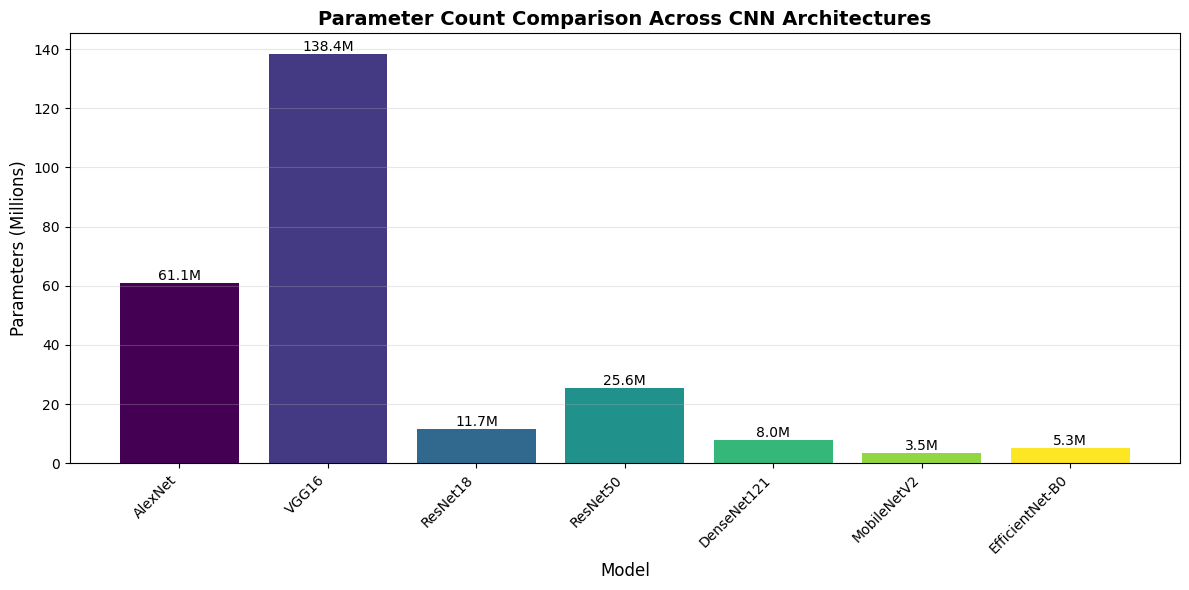

In [30]:
# Visualize parameter comparison
plt.figure(figsize=(12, 6))
colors = plt.cm.viridis(np.linspace(0, 1, len(df)))
bars = plt.bar(df['Model'], df['Parameters (M)'], color=colors)
plt.xlabel('Model', fontsize=12)
plt.ylabel('Parameters (Millions)', fontsize=12)
plt.title('Parameter Count Comparison Across CNN Architectures', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.1f}M',
             ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()

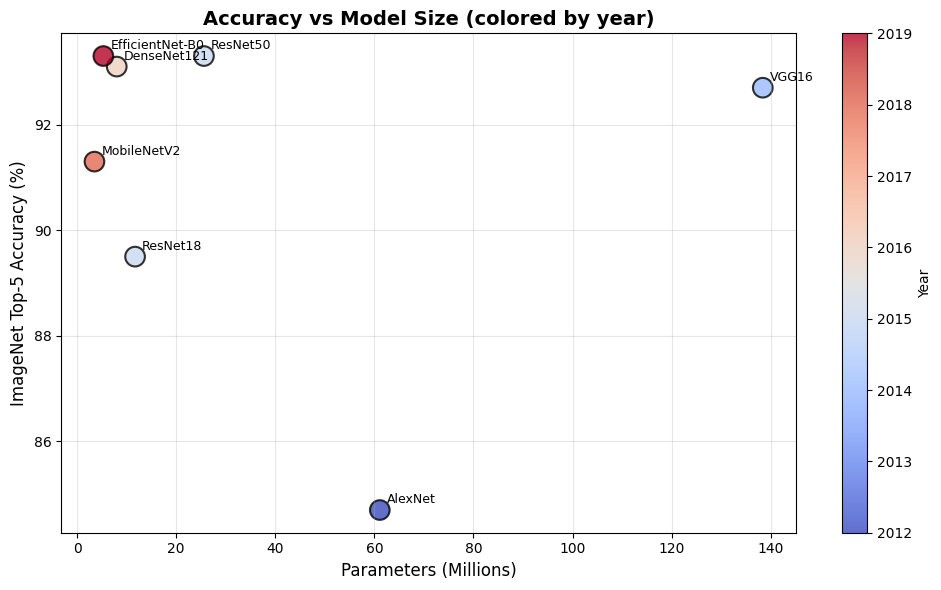

In [31]:
# Visualize accuracy vs parameters
plt.figure(figsize=(10, 6))

# Convert top-5 error to top-5 accuracy
accuracy = 100 - df['ImageNet Top-5 Error (%)']

plt.scatter(df['Parameters (M)'], accuracy, s=200, c=df['Year'], 
           cmap='coolwarm', edgecolors='black', linewidth=1.5, alpha=0.8)

# Add labels for each point
for idx, row in df.iterrows():
    plt.annotate(row['Model'], 
                (row['Parameters (M)'], 100 - row['ImageNet Top-5 Error (%)']),
                xytext=(5, 5), textcoords='offset points', fontsize=9)

plt.xlabel('Parameters (Millions)', fontsize=12)
plt.ylabel('ImageNet Top-5 Accuracy (%)', fontsize=12)
plt.title('Accuracy vs Model Size (colored by year)', fontsize=14, fontweight='bold')
plt.colorbar(label='Year')
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

## Key Takeaways

### Evolution of CNN Architectures:

1. **2012 - AlexNet**: Demonstrated that deep CNNs can work with proper techniques (ReLU, dropout, GPU training)

2. **2014 - VGG**: Showed that depth matters and simple, homogeneous architectures can be very effective

3. **2015 - ResNet**: Solved the degradation problem with skip connections, enabling very deep networks (100+ layers)

4. **2016 - DenseNet**: Improved information flow with dense connections, achieving better accuracy with fewer parameters

5. **2018 - MobileNetV2**: Focused on efficiency for mobile devices using depthwise separable convolutions

6. **2019 - EfficientNet**: Systematic scaling approach achieving best accuracy/efficiency trade-off

### Trends:
- **Increasing depth**: From 8 layers (AlexNet) to 50+ layers (ResNet, DenseNet)
- **Better connectivity**: Skip connections, dense connections
- **Efficiency focus**: MobileNet and EfficientNet achieve high accuracy with fewer parameters
- **Architectural innovations**: From simple stacking to sophisticated building blocks

### Practical Considerations:
- **General purpose**: ResNet50, EfficientNet-B0
- **Feature extraction**: VGG16 (simple, interpretable features)
- **Mobile deployment**: MobileNetV2
- **High accuracy needed**: ResNet101, EfficientNet-B7
- **Parameter efficiency**: DenseNet, EfficientNet

## Understanding Feature Maps

### What are Rectified Feature Maps?

Rectified feature maps are the outputs of convolutional layers after applying the ReLU (Rectified Linear Unit) activation function. These maps show what features the network has learned to detect:

- **Early layers**: Detect low-level features (edges, corners, colors, textures)
- **Middle layers**: Detect mid-level features (shapes, patterns, object parts)
- **Deep layers**: Detect high-level features (whole objects, faces, specific objects)

### Observations from Our Visualizations:

1. **Early layers** show clear edge and texture detection
2. **Deeper layers** show more abstract, semantic features
3. **Different architectures** learn different feature representations
4. **Skip connections** (ResNet) and **dense connections** (DenseNet) affect feature evolution

### Using Hooks:

Forward hooks in PyTorch allow us to:
- Extract intermediate layer outputs without modifying the model
- Visualize what the network "sees"
- Debug and understand model behavior
- Perform feature extraction for transfer learning

---
## References

### Papers:

1. **AlexNet**: Krizhevsky, A., Sutskever, I., & Hinton, G. E. (2012). ImageNet classification with deep convolutional neural networks. In NeurIPS.

2. **VGG**: Simonyan, K., & Zisserman, A. (2014). Very deep convolutional networks for large-scale image recognition. arXiv:1409.1556.

3. **ResNet**: He, K., Zhang, X., Ren, S., & Sun, J. (2016). Deep residual learning for image recognition. In CVPR.

4. **DenseNet**: Huang, G., Liu, Z., Van Der Maaten, L., & Weinberger, K. Q. (2017). Densely connected convolutional networks. In CVPR.

5. **MobileNetV2**: Sandler, M., Howard, A., Zhu, M., Zhmoginov, A., & Chen, L. C. (2018). MobileNetV2: Inverted residuals and linear bottlenecks. In CVPR.

6. **EfficientNet**: Tan, M., & Le, Q. (2019). EfficientNet: Rethinking model scaling for convolutional neural networks. In ICML.

### Additional Resources:

- [PyTorch Vision Models Documentation](https://pytorch.org/vision/stable/models.html)
- [Papers With Code - Image Classification on ImageNet](https://paperswithcode.com/sota/image-classification-on-imagenet)
- [ImageNet Dataset](https://www.image-net.org/)
- [CS231n: Convolutional Neural Networks for Visual Recognition](http://cs231n.stanford.edu/)